# Assignment 3: Generating "Human-Like" Pieces from a Given Corpus

## Part 1: Preprocessing - Parsing the dataset

Goal: Parse the abc music files to only get the elements related to the rhythm and pitch. We will use music21 to obtain, from each piece's abc file, a list of bars with each bar containing the beat onset on which a note appears, and the pitch of each corresponding note in midi number. Then, we will create a Dataframe of all the pieces encoded in list form, which we can split to use as a training set and a test set.

In [2]:
# !pip install music21
# !pip install textract
# !pip install networkx

import pandas as pd
import numpy as np
import random
import ast
import music21
import os
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Here are all the functions we defined for parsing

# Function that, from an abc file, gets the beat distribution and pitch distribution of every bar of the piece
# Returns an array (piece) of arrays (bars)
def extractBeatAndPitchArrays(path):

    # getting the parsable score
    sample = music21.converter.parse(path)
    part = sample.parts[0]
    notes = part.recurse().notes
    length_in_bars = int(sample.duration.quarterLength/sample.getTimeSignatures()[0].numerator) 
    # should be numerator*(denominator/4), but here denominator is already 4 since all pieces are in 3/4
    
    bars_beats = []
    bars_pitches = []

    # iteratively adding every beat of every bar. Each bar is a list and the piece is a list of bars i.e. a list of lists
    for i in range(0, length_in_bars):
        if part.measure(i) is not None:
            notes = part.measure(i).notes
            beats = []
            pitches = []
            for n in notes:
                beats.append(n.beat)
                pitches.append(n.pitch.midi)
                    
        bars_beats.append(beats)
        bars_pitches.append(pitches)
        i += 1

    return bars_beats, bars_pitches

# Function that maps the beat distribution of a bar to a series of numbers between 1 and 12 (position of each sixteenth-note in the bar)
def map_beats(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for x in bar:
            bar_mapped.append(int(4*(x-1)+1))
        notes_mapped.append(bar_mapped)
    return notes_mapped

# Function that maps a series of numbers between 1 and 12 (position of each sixteenth-note in the bar) to a music21 beat distribution
def map_beats_reverse(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for y in bar:
            bar_mapped.append((y+3)/4)
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [ ]:
# Parsing the dataset with the above function

data_parse = pd.DataFrame(columns=['piece', 'beats', 'pitches', 'beat_pitch'])

directory = './abc'

pieces = 0 # check every piece in the directory (599) is encoded

for name in os.listdir(directory):
    pieces += 1
    path = directory + '/' + name 
    bars_beats = []
    bars_pitches = []
    try:
        bars_beats, bars_pitches = extractBeatAndPitchArrays(path)
    except:
        bars_beats = []
        bars_pitches = []

    if ((bars_beats != []) & (bars_pitches != [])): # not adding unparsed pieces to dataframe
        data_parse.loc[len(data_parse)] = [path, bars_beats, bars_pitches, []]

# map the beats to integers and make tuples
for _, d in data_parse.iterrows():
    d['beats'] = map_beats(d['beats'])

    notes = d['beats']
    pitches = d['pitches']

    tuples_note_pitch = []
    for j in range(len(notes)):
        bar_j = []
        for k in range(len(notes[j])):
            bar_j.append((notes[j][k], pitches[j][k]))
        tuples_note_pitch.append(bar_j)
    d['beat_pitch'] = tuples_note_pitch

print("Done")

print(f"{pieces} pieces were analysed.")    

print(f"{len(data_parse)} pieces were correctly parsed.")

Done
599 pieces were analysed.
484 pieces were correctly parsed.


In [ ]:
data_parse.head()

,piece,beats,pitches,beat_pitch
0,./abc/1b651a94a8f8680da3cef1e60705194d.abc,"[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8,...","[[69, 76, 81, 83, 81, 79, 77, 74], [74, 76, 79...","[[(1, 69), (3, 76), (5, 81), (6, 83), (7, 81),..."
1,./abc/3679c385a618c89f00d159f418022b39.abc,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 4, 5, 6, 7, 8,...","[[76, 76, 81, 76, 76, 77, 76, 74], [72, 71, 69...","[[(1, 76), (3, 76), (4, 81), (5, 76), (7, 76),..."
2,./abc/60ae81952628613e03d563b0dae8bbc2.abc,"[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 9, 11]]","[[62, 67, 71, 74, 72, 71, 72, 69], [67, 71, 62...","[[(1, 62), (4, 67), (5, 71), (7, 74), (9, 72),..."
3,./abc/6a7d307d1f0712090e4043a6b4637efa.abc,"[[1, 5, 9], [1, 1, 3, 4, 5, 7, 9, 11], [1, 4, ...","[[64, 69, 71], [71, 72, 71, 72, 74, 72, 71, 69...","[[(1, 64), (5, 69), (9, 71)], [(1, 71), (1, 72..."
4,./abc/8c6965e3c831e8cb769e578423c12d1e.abc,"[[1, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, 9, 10,...","[[69, 67, 66, 67, 69], [69, 71, 73, 74, 73, 74...","[[(1, 69), (5, 67), (7, 66), (8, 67), (9, 69)]..."


In [ ]:
# Testing the function mappings
example_notes = data_parse[data_parse['piece'] == './abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_no_10_d81ffb.abc']['beats'].tolist()[0]
# when we retrieve a specific piece and convert to list it wraps the piece's array in another array for some reason, hence the [0]
# but when doing iterrows we don't have that problem
print("Integer mapping:", example_notes)
map_onset = map_beats_reverse(example_notes)
print("Beat onset mapping:", map_onset)
print("Back to integer mapping:", map_beats(map_onset))

print("Pitches", data_parse[data_parse['piece'] == './abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_no_10_d81ffb.abc']['pitches'].tolist()[0])

Integer mapping: [[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 4, 5, 7, 9, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5, 9], [1, 3, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1, 3, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9, 11], [1, 2, 3, 4, 5, 9]]
Beat onset mapping: [[1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0], [1.0, 1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0], [1.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 3.0], [1.0, 1.5, 2.0, 2.5, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 3.0]]
Back to integer mapping: [[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, 3, 4, 5, 7, 9, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [ ]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
# set random seed for reproducibility
x_train, x_test = train_test_split(data_parse, random_state=42) # split 75% train 25% test

print(len(x_train))
print(len(x_test))

363
121


In [ ]:
# Writing train and test to csv
x_train.to_csv("train.csv", index=False)
x_test.to_csv("test.csv", index=False)

## Part 2: The Random Model

**Goal:** generate random 8-bar melodies (rhythm + pitch). The only constraints are the following: 
- the minimal note duration is a sixteenth note.
- all pitches are between C4 and C5

In [ ]:
import random

random.seed(1113)

In [6]:
# function to fill a bar with random notes
def random_bar():
    # first = True
    first = False
    # first decide how many notes are in the bar
    # (the tempo is always 3/4)
    bar = []
    for i in range(11):
        # decide if a note is played
        if first:
            bar.append(1.0)
            first = False
        elif random.random() < 0.5:
            # if yes, decide which note
            bar.append((i/4)+1)
        # check that the bar is not empty
    if len(bar) == 0:
        bar = random_bar()
    return bar

# create a scale with all the notes from C4 to C5
sc = music21.scale.MajorScale('C4')
# get all the pitches from the scale
pitch_collection = sc.getPitches('C4', 'C5')
print(f"pitch_collection contains {len(pitch_collection)} pitches.")
print(pitch_collection)

# create list with pitches for the bar
def create_pitches(size, pitch_collection= pitch_collection):
    list_p = []
    for i in range(size):
        # append a random pitch from the scale
        list_p.append(random.choice(pitch_collection))
    return list_p

# create random song
def create_random_song():
    # make a list with 8 lists inside
    random_song = [[] for j in range(8)]
    random_pitches = [[] for j in range(8)]
    # for each list in random_song fill it with random notes
    for i in range(8):
        random_song[i] = random_bar()
        random_pitches[i] = create_pitches(len(random_song[i]))
    return random_song, random_pitches

# function to convert from beats into durations
def convert_to_duration(random_song_list):

    last = 3.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 3.0
    # reverse the list again
    duration_list.reverse()
    # return original order to original song aswell
    random_song_list.reverse()
    for bar in random_song_list:
        bar.reverse()
    return duration_list

# Function that creates a list of notes from pitches
def elongate_pitch_list(pitch_list):
    new_list = []
    for bar in pitch_list:
        for note in bar:
            new_list.append(note)
    return new_list

# translate the music21 pitches to midi numbers
def translate_pitches(pitches):
    midi_pitches = []
    for bar in pitches:
        bar_midi = []
        for pitch in bar:
            bar_midi.append(pitch.midi)
        midi_pitches.append(bar_midi)
    return midi_pitches

# convert durations and pitches to a midi stream
def convert_to_stream(duration_list, pitch_list):
    pitch_list = elongate_pitch_list(pitch_list)
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign the pitch of the random_pitches list
    # assign duration (quarter)
    # append the note into empty stream
    count = 0
    for duration in duration_list:
        note = music21.note.Note(pitch=pitch_list[count], quarterLength=duration)
        stream.append(note)
        count += 1
    return stream


pitch_collection contains 8 pitches.
[<music21.pitch.Pitch C4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C5>]


In [ ]:
# example
random_song, random_pitches = create_random_song()
print('Random song: ', random_song)
print('Random pitches: ', random_pitches)
duration_list = convert_to_duration(random_song)
print('Duration list example: ', duration_list)

# print with map_beats conversion (map_beats function from Part 1) and without
print('Random sequence represented by integers:\n', map_beats(random_song))
print('Random sequence represented by beat onsets:\n', map_beats_reverse(map_beats(random_song)))
print('Random song with pitches as midi numbers: ', translate_pitches(random_pitches))

# midi conversion
stream = convert_to_stream(duration_list, random_pitches)
stream.show('midi')

Random song:  [[1.75, 2.0, 2.25, 2.75, 3.25, 3.5], [1.0, 1.25, 1.5, 2.25, 2.75, 3.5], [2.0, 2.25, 2.75, 3.0, 3.25, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75], [1.0, 1.5, 1.75, 2.25, 2.75, 3.25, 3.5], [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.5], [1.0, 2.25, 3.25, 3.5], [1.0, 1.5, 2.0]]
Random pitches:  [[<music21.pitch.Pitch A4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch E4>], [<music21.pitch.Pitch E4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch A4>], [<music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch B4>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch B4>], [<m

In [ ]:
# produce a dataframe size 500 samples and save it as csv

# os.mkdir("./random_rhythms") # this was run once, no need to run it again

# produce a dataframe size 500 samples and save it as csv
def produce_dataframe():
    df = pd.DataFrame(columns=['id', 'beats', 'pitches', 'tuple_beat_and_pitch', 'midi'])
    for i in range(500):
        random_song, random_pitches = create_random_song()
        # write stream to midi file
        stream = convert_to_stream(convert_to_duration(random_song),random_pitches)
        # save midi in the random_midis folder
        file_midi = f'random_midis/random_song_{i}.mid'
        stream.write('midi', file_midi)
        notes = map_beats(random_song)
        pitches = translate_pitches(random_pitches)
        tuples_note_pitch = []
        for j in range(len(notes)):
            bar_j = []
            for k in range(len(notes[j])):
                bar_j.append((notes[j][k], pitches[j][k]))
            tuples_note_pitch.append(bar_j)
        df.loc[len(df)] = [i, notes, pitches, tuples_note_pitch, file_midi]
    df.to_csv('random_songs.csv', index=False)
    return df

# our data
df = produce_dataframe()
print(f"{len(df)} random songs generated.")

# save
df.to_csv('random_songs.csv', index=False)

# display
df.head()

500 random songs generated.


,id,beats,pitches,tuple_beat_and_pitch,midi
0,0,"[[1, 3, 4, 6], [2, 3, 4, 5, 7, 10], [1, 4, 5, ...","[[62, 67, 65, 65], [72, 65, 62, 60, 71, 60], [...","[[(1, 62), (3, 67), (4, 65), (6, 65)], [(2, 72...",random_midis/random_song_0.mid
1,1,"[[2, 3, 4, 5, 6, 8, 9, 11], [2, 3, 4, 5, 6, 10...","[[67, 72, 60, 69, 64, 62, 62, 60], [67, 71, 67...","[[(2, 67), (3, 72), (4, 60), (5, 69), (6, 64),...",random_midis/random_song_1.mid
2,2,"[[1, 2, 3, 4, 6, 7, 8], [1, 3, 5, 6, 7, 9, 11]...","[[67, 69, 60, 72, 72, 72, 60], [65, 64, 69, 71...","[[(1, 67), (2, 69), (3, 60), (4, 72), (6, 72),...",random_midis/random_song_2.mid
3,3,"[[1, 3, 4, 5, 6, 8, 9, 10, 11], [3, 4, 6, 7, 9...","[[65, 60, 67, 65, 69, 72, 69, 71, 65], [62, 62...","[[(1, 65), (3, 60), (4, 67), (5, 65), (6, 69),...",random_midis/random_song_3.mid
4,4,"[[4, 5, 6, 8, 9], [1, 2, 4, 6, 8, 10, 11], [1,...","[[69, 60, 64, 65, 72], [67, 60, 62, 62, 64, 64...","[[(4, 69), (5, 60), (6, 64), (8, 65), (9, 72)]...",random_midis/random_song_4.mid


In [ ]:
# Testing the tuple format
print(df[['tuple_beat_and_pitch']])

                                  tuple_beat_and_pitch
0    [[(1, 62), (3, 67), (4, 65), (6, 65)], [(2, 72...
1    [[(2, 67), (3, 72), (4, 60), (5, 69), (6, 64),...
2    [[(1, 67), (2, 69), (3, 60), (4, 72), (6, 72),...
3    [[(1, 65), (3, 60), (4, 67), (5, 65), (6, 69),...
4    [[(4, 69), (5, 60), (6, 64), (8, 65), (9, 72)]...
..                                                 ...
495  [[(1, 67), (3, 62), (4, 69), (8, 64), (9, 64),...
496  [[(3, 69), (4, 60), (6, 72), (8, 69), (9, 72),...
497  [[(3, 72), (4, 62), (5, 60), (7, 62), (10, 62)...
498  [[(2, 72), (5, 67), (7, 72), (8, 67), (9, 67)]...
499  [[(2, 62), (3, 64), (4, 69), (5, 72), (6, 71),...

[500 rows x 1 columns]


## Part 3: The Generation Model

**Goal:** generate "human-like" 8-bar melodies in the style of Slängpolska. We will use a bigram-based Markov chain model, trained on 75% of the dataset as per the train-test split done in part 1.

In [ ]:
np.random.seed(401)

data = pd.read_csv('train.csv')
data.head()

,piece,beats,pitches,beat_pitch
0,./abc/_Polonäs_sexdregasamlingen_del_2_nr_43_9...,"[[1, 5, 7, 9, 11], [1, 3, 5, 7, 9, 11], [1, 5,...","[[74, 69, 67, 66, 64], [62, 79, 78, 76, 78, 76...","[[(1, 74), (5, 69), (7, 67), (9, 66), (11, 64)..."
1,./abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_n...,"[[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, ...","[[67, 79, 79, 78, 79, 76], [76, 78, 79, 76, 74...","[[(1, 67), (3, 79), (5, 79), (7, 78), (9, 79),..."
2,./abc/Polska_efter_Anders_Gustaf_Andersson_0ac...,"[[1, 3, 5, 7, 9, 11], [1, 3, 4, 5, 9], [1, 1, ...","[[81, 76, 77, 76, 77, 79], [81, 77, 81, 79, 76...","[[(1, 81), (3, 76), (5, 77), (7, 76), (9, 77),..."
3,./abc/Polonäs_9c99ae.abc,"[[1, 2, 3, 4, 5, 7, 9, 10, 11, 12], [1, 4, 5, ...","[[74, 72, 70, 69, 67, 62, 60, 58, 57, 55], [67...","[[(1, 74), (2, 72), (3, 70), (4, 69), (5, 67),..."
4,./abc/_Polonäs_sexdregasamlingen_del_2_nr_76_5...,"[[1, 3, 4, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1...","[[79, 78, 76, 74, 72, 71], [67, 67, 71, 69, 69...","[[(1, 79), (3, 78), (4, 76), (5, 74), (7, 72),..."


In [ ]:
import ast
# change the note column to list
data['beats'] = data['beats'].apply(ast.literal_eval)
data['pitches'] = data['pitches'].apply(ast.literal_eval)
data['beat_pitch'] = data['beat_pitch'].apply(ast.literal_eval)

In [ ]:
from collections import defaultdict
from collections import Counter

# get the bigram of the music data
bigram = []
bigram_freq = defaultdict(int)

# get the bigram of each song
for i in range(len(data)):
    for bar in data.loc[i,'beat_pitch']:
        bigram.extend(zip(bar, bar[1:]))
    
# get the frequency of every bigram
bigram_freq = dict(Counter(bigram))
print("Frequency of every bigram:", len(bigram_freq))

# remove the identical bigram or bigram with wrong direction
wrong_bigrams = []
for key in bigram_freq:
    if key[0][0] >= key[1][0] or key[1][0]>12:
        wrong_bigrams.append(key)
for key in wrong_bigrams:
    del bigram_freq[key]
print("Frequency of correct bigrams:", len(bigram_freq))

Frequency of every bigram: 3956
Frequency of correct bigrams: 3854


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

position_pitch_freq = defaultdict(int)

for beat_pitch in data['beat_pitch']:
    for bar in beat_pitch:
        for (pos, pitch) in bar:
            if pos <13:
                position_pitch_freq[(pos,pitch)] += 1

# Convert the defaultdict to a DataFrame
df = pd.DataFrame.from_dict(position_pitch_freq, orient='index')

# Reset the index and rename the columns
df = df.reset_index()
df.columns = ['Position_Pitch', 'Frequency']

# Create separate columns for Position and Pitch
df[['Position', 'Pitch']] = pd.DataFrame(df['Position_Pitch'].tolist(), index=df.index)
df = df.drop('Position_Pitch', axis=1)

# Pivot the DataFrame to create a multi-index with Position and Pitch
df_pivot = df.pivot_table(index='Pitch', columns='Position', values='Frequency', fill_value=0)

# Sort the DataFrame by the index (Pitch) in ascending order
df_pivot = df_pivot.sort_index(ascending=False)

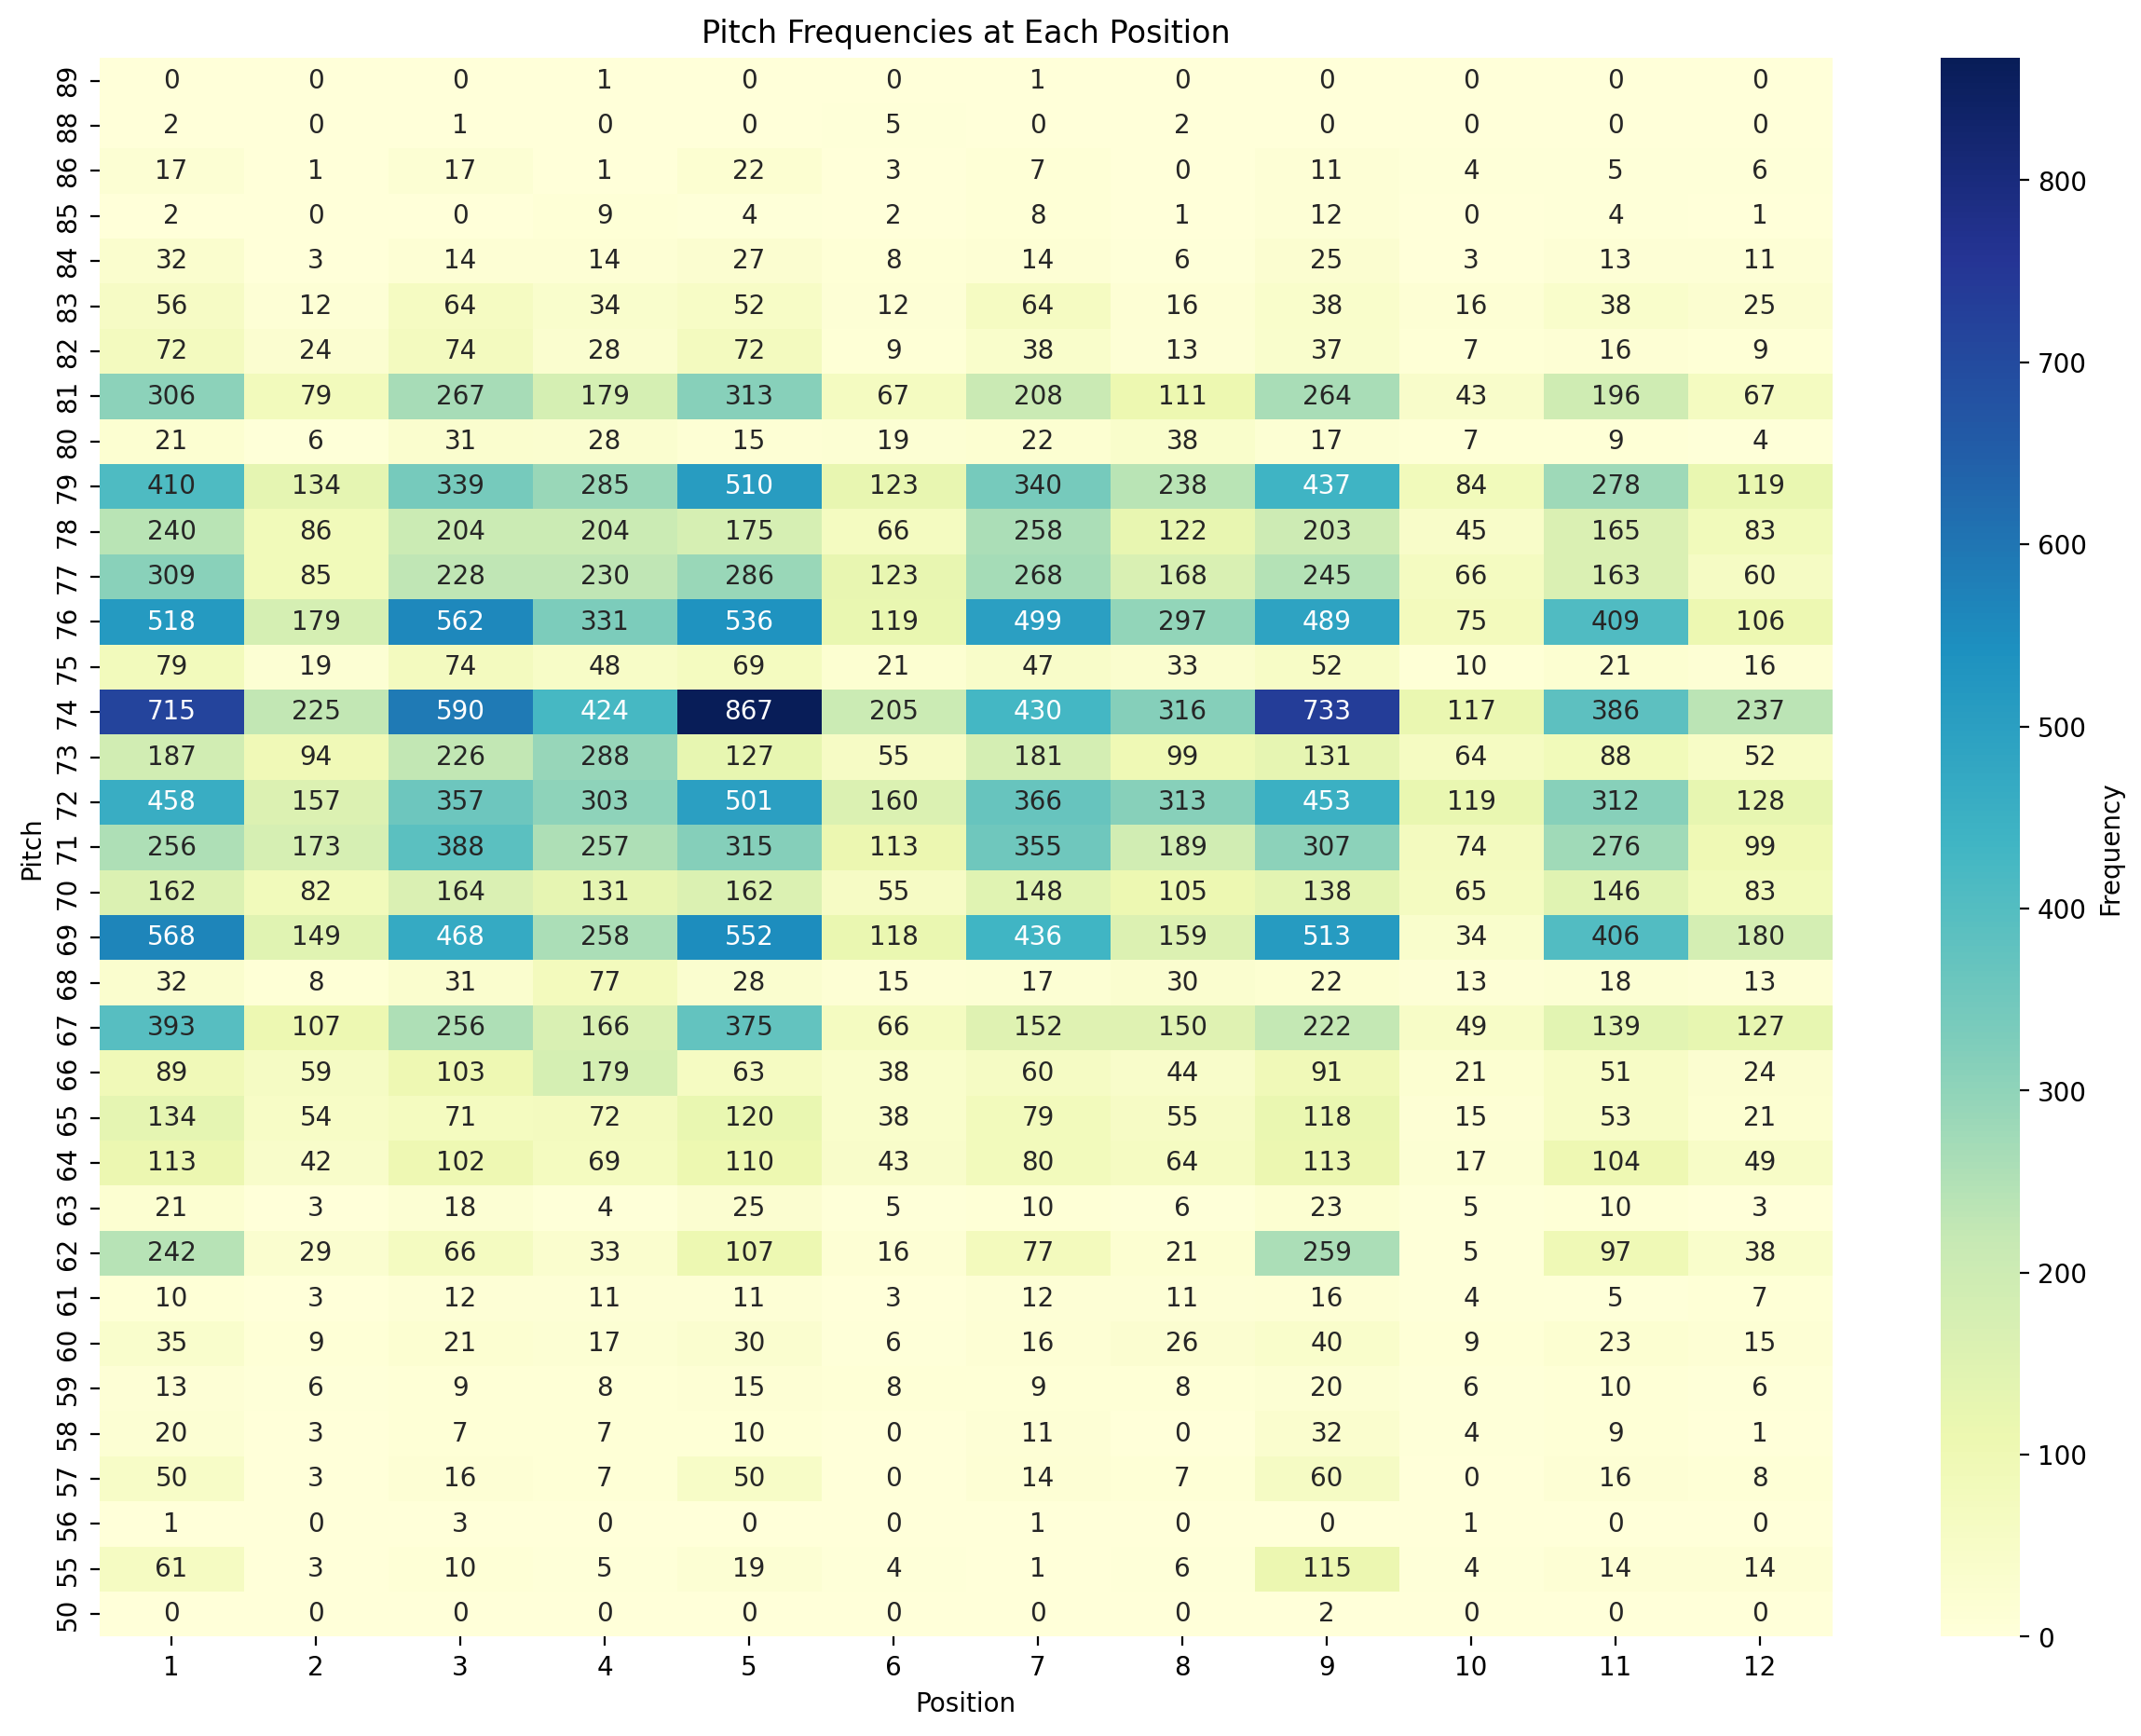

In [ ]:
plt.figure(figsize=(15, 11))
sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.xlabel("Position")
plt.ylabel("Pitch")
plt.title("Pitch Frequencies at Each Position")
plt.savefig('pitch_frequency.png')
plt.show()

In [ ]:
# the generation model

# use the current position to predict the next position
def predict_next_state(bigram_freq, current_state):
    """
    predict the next state based on the bigram frequency
    """
    # get the possible next states
    possible_next_states = [k[1] for k, v in bigram_freq.items() if k[0] == current_state]
    # get the frequency of each possible next state
    freq = [v for k, v in bigram_freq.items() if k[0] == current_state]
    # normalize the frequency
    freq = np.array(freq) / np.sum(freq)
    # predict the next state
    next_state = random.choices(possible_next_states, weights=freq,k=1)[0]
    return next_state

# get the cosine similarity between two bars
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# change the position list to a vector of length 12
def seq_to_vec(seq):
    vec = [0] * 12
    for tup in seq:
        vec[tup[0]-1] = tup[1]
    return vec

# given the start position, generate a bar
def generate_a_bar(bigram_freq, start_state):
    """
    generate a bar based on the bigram frequency
    """
    bar = [start_state]
    while True:
        next_state = predict_next_state(bigram_freq, bar[-1])
        bar.append(next_state)
        # stop when the next state is 12 or the bar is longer than 4 and the next state is larger than 9 at the probability of 0.6
        if next_state[0] == 12 or (len(bar) >= 4 and next_state[0] >= 9 and np.random.random() > 0.6):
            break
    return bar

# generate a sequence of bars
def generate_sequence(bigram_freq, start_state, num_bars, similarity_threshold=0.5):
    """
    generate a sequence based on the bigram frequency
    """
    sequence = [generate_a_bar(bigram_freq, start_state)]
    while len(sequence) < num_bars:
        bar = generate_a_bar(bigram_freq, start_state)
        # compare the similarity between the last bar in the sequence and the new bar
        vec1 = seq_to_vec(sequence[-1])
        vec2 = seq_to_vec(bar)
        similarity = cosine_similarity(vec1, vec2)

        if similarity >= similarity_threshold:
            sequence.append(bar)

    return sequence

In [ ]:
# example: generating one sequence/song based on the bigram frequency
sequence = generate_sequence(bigram_freq, start_state=(1,72),num_bars=8,similarity_threshold=0.85)
print(sequence)

[[(1, 72), (3, 76), (4, 77), (5, 74), (7, 72), (8, 71), (9, 69)], [(1, 72), (2, 69), (3, 71), (4, 73), (5, 73), (7, 76), (8, 77), (9, 76), (10, 74)], [(1, 72), (2, 69), (3, 65), (4, 68), (5, 68), (7, 69), (8, 67), (9, 69), (12, 66)], [(1, 72), (3, 72), (4, 74), (5, 70), (7, 69), (8, 72), (9, 74)], [(1, 72), (2, 71), (3, 74), (4, 77), (5, 74), (7, 72), (8, 70), (9, 69), (11, 72), (12, 55)], [(1, 72), (4, 82), (5, 81), (7, 82), (8, 79), (9, 78), (11, 74), (12, 78)], [(1, 72), (3, 71), (5, 72), (7, 74), (8, 72), (9, 74), (11, 72), (12, 74)], [(1, 72), (3, 71), (4, 55), (5, 71), (7, 80), (9, 81), (11, 79), (12, 76)]]


In [ ]:
# calculate the most common start state
start_states = []
for i in range(len(data)):
    for bar in data.loc[i,'beat_pitch']:
        try:
            start_states.append(bar[0])
        except:
            pass
start_states = dict(Counter(start_states))
print(len(start_states))

42


In [5]:
# Convert list of bars of midi numbers to music21 pitches
def convert_midinum_to_pitch(midinums):
    pitch_list = []
    for i in range(len(midinums)):
        bar_i = []
        for j in range(len(midinums[i])):
            bar_i.append(music21.pitch.Pitch(midinums[i][j]))
        pitch_list.append(bar_i)
    return pitch_list

In [ ]:
# generate 500 sequences based on the most common start state
sequences = pd.DataFrame(columns=['beat','pitch','beat_pitch', 'midi'])
i = 0
while i < 500:
    try:
        # print(i) # used for debug
        # randomly choose a start state
        start_state = random.choices(list(start_states.keys()), weights=list(start_states.values()),k=1)[0]
        sequence = generate_sequence(bigram_freq, start_state=start_state,num_bars=8,similarity_threshold=0.85)
        beats = []
        pitches = []
        for bar in sequence:
            beats.append([beat for (beat, pitch) in bar])
            pitches.append([pitch for (beat, pitch) in bar])
        
        # creating the midi
        beats_for_midi = map_beats_reverse(beats)
        pitches_for_midi = convert_midinum_to_pitch(pitches)
        # if (i==0): # debug
        #    print(beats_for_midi) # debug
        #    print(pitches_for_midi) # debug
        stream = convert_to_stream(convert_to_duration(beats_for_midi), pitches_for_midi)
        # save midi in the markov_midis folder
        file_midi = f'markov_midis/markov_song{i}.mid'
        stream.write('midi', file_midi)

        sequences.loc[len(sequences)] = [beats, pitches, sequence, file_midi]
    except:
        i -= 1

    i += 1
  
sequences.to_csv('markov_songs_with_pitch.csv',index=True)

##### Another Model: the LSTM Model

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
import ast
import music21
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
random.seed(10)

In [ ]:
data_train = pd.read_csv('./train.csv')
data_train['beat_pitch'] = data_train['beat_pitch'].apply(ast.literal_eval)
data_train['pitches'] = data_train['pitches'].apply(ast.literal_eval)

In [ ]:
high=0
low=0
for i in range(len(data_train['pitches'])):
    piece=data_train['pitches'][i]  
    piece=np.array(sum(piece,[]))    
    if high<np.max(piece):
        high=np.max(piece)
    if low>np.min(piece):
        low=np.min(piece)
print(high)
print(low)

89
0


In [ ]:
def format_transition_1(piece):
    # Transfer the beat_pitch format to 12-position 1-12 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12
    re=np.zeros((len(piece),12))
    for i in range(len(piece)):
        bar=piece[i]
        for j in range(len(bar)):            
            re[i][bar[j][0]-1]=(bar[j][1]-low)/(high-low)  
            #print(i)
            #print(j)
    return re

In [ ]:
class LSTM(nn.Module):
    def __init__(self, INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional):
        super(LSTM, self).__init__()

        self.LSTM = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=Bidirectional,
            proj_size=0
        )

        self.out1 = nn.Linear(HIDDEN_SIZE*SEQ_LEN,2*OUTPUT_SIZE)
        self.out2=nn.Linear(2*OUTPUT_SIZE,OUTPUT_SIZE)
    

    def forward(self, x, hidden_state):
        output, h_state = self.LSTM(x,hidden_state)        
        outs = []  #for different batch
        for time in range(output.size(0)):
            out=self.out1(output[time, :, :].reshape(-1))
            out=self.out2(out)
            out[out<0.1]=0
            outs.append(out)            
        return torch.stack(outs, dim=1), h_state

##### Prediction for the Beginning

In [ ]:
INPUT_SIZE=12*2    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=4    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*2    # number of notes for predicted result
lr=0.01
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=16
EPOCH=20

model1:
 LSTM(
  (LSTM): LSTM(24, 15, batch_first=True)
  (out1): Linear(in_features=60, out_features=24, bias=True)
  (out2): Linear(in_features=48, out_features=24, bias=True)
)
1
loss: tensor(0.4850, grad_fn=<L1LossBackward>)
2
loss: tensor(0.5054, grad_fn=<L1LossBackward>)
3
loss: tensor(0.4700, grad_fn=<L1LossBackward>)
4
loss: tensor(0.4202, grad_fn=<L1LossBackward>)
5
loss: tensor(0.4602, grad_fn=<L1LossBackward>)
6
loss: tensor(0.4572, grad_fn=<L1LossBackward>)
7
loss: tensor(0.4530, grad_fn=<L1LossBackward>)
8
loss: tensor(0.4465, grad_fn=<L1LossBackward>)
9
loss: tensor(0.4298, grad_fn=<L1LossBackward>)
10
loss: tensor(0.4452, grad_fn=<L1LossBackward>)
11
loss: tensor(0.4151, grad_fn=<L1LossBackward>)
12
loss: tensor(0.4070, grad_fn=<L1LossBackward>)
13
loss: tensor(0.4212, grad_fn=<L1LossBackward>)
14
loss: tensor(0.4725, grad_fn=<L1LossBackward>)
15
loss: tensor(0.4521, grad_fn=<L1LossBackward>)
16
loss: tensor(0.4170, grad_fn=<L1LossBackward>)
1
loss: tensor(0.4340, grad_f

4
loss: tensor(0.4152, grad_fn=<L1LossBackward>)
5
loss: tensor(0.4196, grad_fn=<L1LossBackward>)
6
loss: tensor(0.3874, grad_fn=<L1LossBackward>)
7
loss: tensor(0.4333, grad_fn=<L1LossBackward>)
8
loss: tensor(0.4104, grad_fn=<L1LossBackward>)
9
loss: tensor(0.4207, grad_fn=<L1LossBackward>)
10
loss: tensor(0.4171, grad_fn=<L1LossBackward>)
11
loss: tensor(0.4352, grad_fn=<L1LossBackward>)
12
loss: tensor(0.4338, grad_fn=<L1LossBackward>)
13
loss: tensor(0.4237, grad_fn=<L1LossBackward>)
14
loss: tensor(0.3781, grad_fn=<L1LossBackward>)
15
loss: tensor(0.4046, grad_fn=<L1LossBackward>)
16
loss: tensor(0.4374, grad_fn=<L1LossBackward>)
1
loss: tensor(0.4162, grad_fn=<L1LossBackward>)
2
loss: tensor(0.3985, grad_fn=<L1LossBackward>)
3
loss: tensor(0.3683, grad_fn=<L1LossBackward>)
4
loss: tensor(0.4409, grad_fn=<L1LossBackward>)
5
loss: tensor(0.4343, grad_fn=<L1LossBackward>)
6
loss: tensor(0.4232, grad_fn=<L1LossBackward>)
7
loss: tensor(0.4337, grad_fn=<L1LossBackward>)
8
loss: tenso

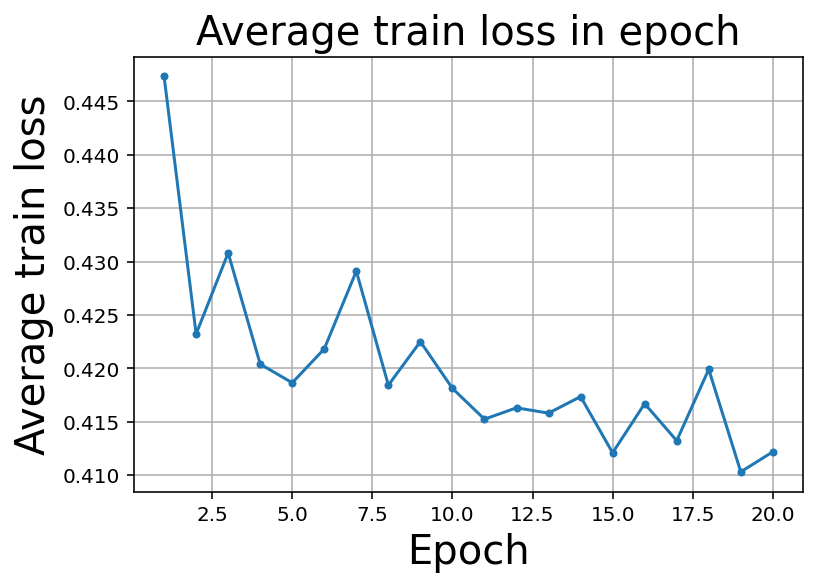

In [ ]:
def train():
    model1 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model1:\n', model1)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model1.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[]  
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                     
                x_x=[]                
                while(j!=SEQ_LEN):                
                    try:
                        piece_now=format_transition_1(data_train['beat_pitch'][counter])                        
                        x_x.append(np.append(piece_now[0],piece_now[1]))                        
                        j=j+1  
                        counter=counter+1                        
                    except:
                        counter=counter+1
                        continue  
                counter=counter-3               
                i=i+1
                x.append(x_x)
                y_index=random.randint(0,362)
                y_piece=format_transition_1(data_train['beat_pitch'][y_index])
                while(True):
                    if len(y_piece)>=2:
                        break
                    else:
                        y_index=random.randint(0,362)
                        y_piece=format_transition_1(data_train['beat_pitch'][y_index])
                y.append(np.append(y_piece[0],y_piece[1]))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([INPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model1(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model1.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model1.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model1,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model1,hidden_state1=train()

##### Generation for the Ending: uses the generated beginning

In [ ]:
INPUT_SIZE=12    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=2    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*2    # number of notes for predicted result
lr=0.002
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=16
EPOCH=10

model2:
 LSTM(
  (LSTM): LSTM(12, 15, batch_first=True)
  (out1): Linear(in_features=30, out_features=48, bias=True)
  (out2): Linear(in_features=48, out_features=24, bias=True)
)
1
loss: tensor(0.4441, grad_fn=<L1LossBackward>)
2
loss: tensor(0.4708, grad_fn=<L1LossBackward>)
3
loss: tensor(0.4434, grad_fn=<L1LossBackward>)
4
loss: tensor(0.4430, grad_fn=<L1LossBackward>)
5
loss: tensor(0.4461, grad_fn=<L1LossBackward>)
6
loss: tensor(0.4695, grad_fn=<L1LossBackward>)
7
loss: tensor(0.4517, grad_fn=<L1LossBackward>)
8
loss: tensor(0.4248, grad_fn=<L1LossBackward>)
9
loss: tensor(0.4546, grad_fn=<L1LossBackward>)
10
loss: tensor(0.4812, grad_fn=<L1LossBackward>)
11
loss: tensor(0.4385, grad_fn=<L1LossBackward>)
12
loss: tensor(0.4738, grad_fn=<L1LossBackward>)
13
loss: tensor(0.4823, grad_fn=<L1LossBackward>)
14
loss: tensor(0.4216, grad_fn=<L1LossBackward>)
15
loss: tensor(0.4059, grad_fn=<L1LossBackward>)
16
loss: tensor(0.4630, grad_fn=<L1LossBackward>)
1
loss: tensor(0.4171, grad_f

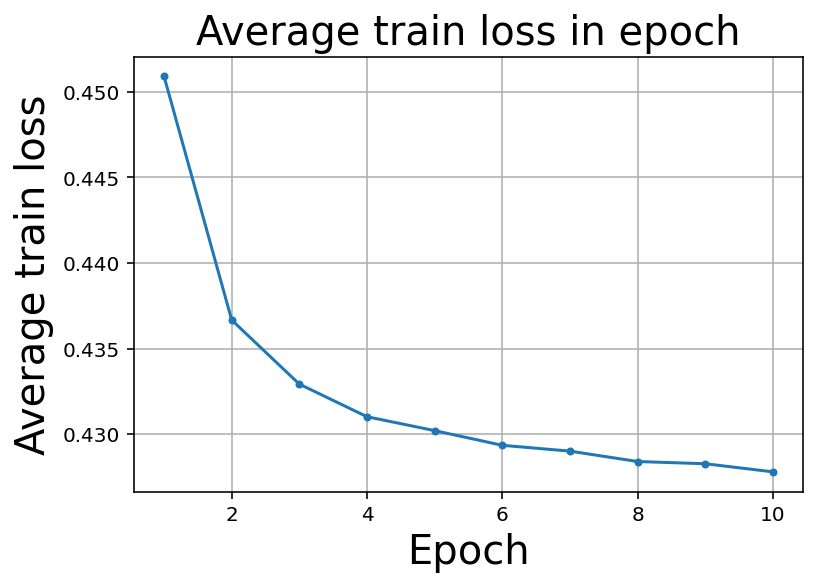

In [ ]:
def train():
    model2 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model2:\n', model2)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model2.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[] 
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                     
                x_x=[]   
                piece_now=format_transition_1(data_train['beat_pitch'][counter])
                while(j!=SEQ_LEN):                
                    try:                                                
                        x_x.append(piece_now[0])
                        x_x.append(piece_now[1])
                        j=j+2  
                        counter=counter+1
                    except:
                        counter=counter+1
                        continue                              
                i=i+1
                x.append(x_x)                
                y.append(np.append(piece_now[-2],piece_now[-1]))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([OUTPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model2(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model2.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model2.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model2,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model2,hidden_state2=train()

##### Prediction for the middle

In [ ]:
INPUT_SIZE=12    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=4    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*4    # number of notes for predicted result
lr=0.002
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=16
EPOCH=10

model3:
 LSTM(
  (LSTM): LSTM(12, 15, batch_first=True)
  (out1): Linear(in_features=60, out_features=96, bias=True)
  (out2): Linear(in_features=96, out_features=48, bias=True)
)
1
loss: tensor(0.4655, grad_fn=<L1LossBackward>)
2
loss: tensor(0.5591, grad_fn=<L1LossBackward>)
3
loss: tensor(0.5058, grad_fn=<L1LossBackward>)
4
loss: tensor(0.5173, grad_fn=<L1LossBackward>)
5
loss: tensor(0.5201, grad_fn=<L1LossBackward>)
6
loss: tensor(0.5216, grad_fn=<L1LossBackward>)
7
loss: tensor(0.4937, grad_fn=<L1LossBackward>)
8
loss: tensor(0.4664, grad_fn=<L1LossBackward>)
9
loss: tensor(0.5061, grad_fn=<L1LossBackward>)
10
loss: tensor(0.5010, grad_fn=<L1LossBackward>)
11
loss: tensor(0.4719, grad_fn=<L1LossBackward>)
12
loss: tensor(0.4770, grad_fn=<L1LossBackward>)
13
loss: tensor(0.4933, grad_fn=<L1LossBackward>)
14
loss: tensor(0.4823, grad_fn=<L1LossBackward>)
15
loss: tensor(0.4797, grad_fn=<L1LossBackward>)
16
loss: tensor(0.5075, grad_fn=<L1LossBackward>)
1
loss: tensor(0.4453, grad_f

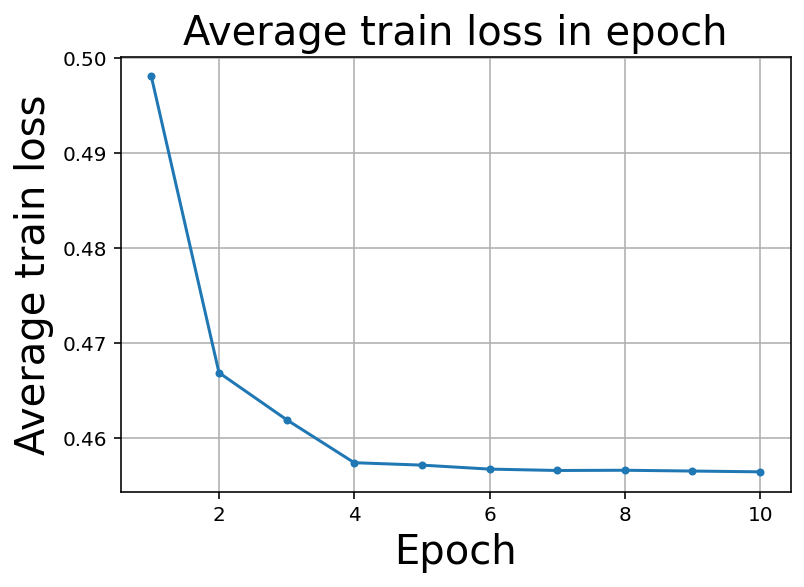

In [ ]:
def train():
    model3 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model3:\n', model3)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model3.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[] 
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                                          
                piece_now=[]
                while(j!=SEQ_LEN):  
                    x_x=[]
                    piece_now=format_transition_1(data_train['beat_pitch'][counter])
                    try:                                                
                        x_x.append(piece_now[0])
                        x_x.append(piece_now[1])
                        x_x.append(piece_now[-2])
                        x_x.append(piece_now[-1])
                        test=piece_now[3] # to test if the piece have more than 3 bars
                        j=j+4  
                        counter=counter+1
                    except:
                        counter=counter+1
                        continue                  
                i=i+1                
                x.append(x_x)                  
                piece1=np.append(piece_now[2],piece_now[3])
                piece2=np.append(piece_now[-4],piece_now[-3])
                y.append(np.append(piece1,piece2))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([OUTPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model3(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model3.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model3.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model3,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model3,hidden_state3=train()

#### Prediction: Generating music based on the test set

In [ ]:
data_test = pd.read_csv('./test.csv')
data_test['beat_pitch'] = data_test['beat_pitch'].apply(ast.literal_eval)
data_test['pitches'] = data_test['pitches'].apply(ast.literal_eval)

In [ ]:
test_generate_beginning=[]
for r in range(5):
    data1=[]
    for i in range(20):
        # generate the beginning
        beginning_data=[]
        j=0
        while(j!=4):
            index=random.randint(0,len(data_test)-1)                            
            try:      
                piece_now=format_transition_1(data_test['beat_pitch'][index]) 
                beginning_data.append(np.append(piece_now[0],piece_now[1])) 
                j=j+1
            except:
                continue
        beginning_data=np.array(beginning_data)               
        beginning_data = beginning_data.reshape([4, 12*2])    
        data1.append(beginning_data)
    
    data1=np.array(data1)
    data1 = data1.reshape([20,4, 12*2])
    data1=torch.tensor(data1,dtype=torch.float32)

    predict_beginning=[]
    with torch.no_grad():        
        model1.eval()
        pred,new_hidden_state = model1(data1, hidden_state1)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_beginning=pred.tolist()
    test_generate_beginning.append(predict_beginning)
    r=r+1


In [ ]:
test_generate_beginning=np.array(test_generate_beginning).reshape((100,24))
test_generate_beginning=test_generate_beginning.tolist()
print(test_generate_beginning[44])

[0.0, 0.7272104620933533, 0.7498549818992615, 0.7161008715629578, 0.0, 0.7568453550338745, 0.0, 0.0, 0.0, 0.768989622592926, 0.7642086744308472, 0.7625542879104614, 0.6984226703643799, 0.7588868141174316, 0.0, 0.0, 0.7528326511383057, 0.760411262512207, 0.0, 0.7663604617118835, 0.7491250038146973, 0.0, 0.0, 0.0]


In [ ]:
test_generate_endding=[]
for r in range(5):
    data2=[]
    for i in range(20):
        # generate the endding
        endding_data=[]
        p1=test_generate_beginning[20*r+i][0:12]
        p2=test_generate_beginning[20*r+i][12:24]
        endding_data.append(p1)
        endding_data.append(p2)    
        data2.append(endding_data)
    
    data2=np.array(data2)
    data2 = data2.reshape([20,2,12])
    data2=torch.tensor(data2,dtype=torch.float32)

    predict_endding=[]
    with torch.no_grad():        
        model2.eval()
        pred,new_hidden_state = model2(data2, hidden_state2)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_endding=pred.tolist()  
    test_generate_endding.append(predict_endding)

In [ ]:
test_generate_endding=np.array(test_generate_endding).reshape((100,24))
test_generate_endding=test_generate_endding.tolist()
print(np.shape(test_generate_endding))

(100, 24)


In [ ]:
test_generate_middle=[]
for r in range(5):
    data3=[]
    for i in range(20):
        # generate the middle
        middle_data=[]
        p1=test_generate_beginning[20*r+i][0:12]
        p2=test_generate_beginning[20*r+i][12:24]
        p3=test_generate_endding[20*r+i][0:12]
        p4=test_generate_endding[20*r+i][12:24]
        middle_data.append(p1)
        middle_data.append(p2)    
        middle_data.append(p3)
        middle_data.append(p4)
        data3.append(middle_data)
    
    data3=np.array(data3)
    data3 = data3.reshape([20,4,12])
    data3=torch.tensor(data3,dtype=torch.float32)

    predict_middle=[]
    with torch.no_grad():        
        model3.eval()
        pred,new_hidden_state = model3(data3, hidden_state3)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_middle=pred.tolist()
    test_generate_middle.append(predict_middle)    

In [ ]:
test_generate_middle=np.array(test_generate_middle).reshape((100,48))
test_generate_middle=test_generate_middle.tolist()
print(np.shape(test_generate_middle))

(100, 48)


In [ ]:
# combine three parts
test_predict_result=[]
for i in range(100):    
    piece=test_generate_beginning[i]+test_generate_middle[i]+test_generate_endding[i]
    test_predict_result.append(piece)
test_predict_result=np.array(test_predict_result)
test_predict_result=np.floor((test_predict_result)*(high-low)+low)
print(test_predict_result)

[[ 0. 62. 58. ...  0. 50.  0.]
 [ 0. 43. 45. ...  0. 47.  0.]
 [ 0. 63. 62. ...  0. 43.  0.]
 ...
 [ 0. 73. 70. ...  0. 49.  0.]
 [ 0. 48. 44. ...  0. 47.  0.]
 [ 0. 39. 34. ...  0. 48.  0.]]


In [ ]:
print(test_predict_result[84])

[ 0. 52. 49.  0. 57. 51.  0. 50.  0. 51. 56. 53. 55.  0.  0.  0.  0. 53.
 53.  0. 49. 54. 57.  0.  0.  0.  0.  0. 57.  0.  0. 57.  0.  0.  0.  0.
  0.  0.  0. 57. 56. 62.  0. 56.  0.  0.  0. 59. 54. 57.  0. 64. 61.  0.
  0.  0.  0.  0.  0.  0. 62.  0.  0.  0.  0. 55. 57.  0.  0. 61.  0.  0.
  0. 59.  0. 60.  0.  0.  0. 59. 50.  0.  0.  0.  0. 60.  0. 53. 53.  0.
  0.  0.  0.  0. 50.  0.]


In [ ]:
df=pd.DataFrame(test_predict_result)
df.to_csv("./test_generat.csv")

In [ ]:
train_generate_beginning=[]
for r in range(20):
    data1=[]
    for i in range(20):
        # generate the beginning
        beginning_data=[]
        j=0
        while(j!=4):
            index=random.randint(0,len(data_train)-1)                            
            try:      
                piece_now=format_transition_1(data_train['beat_pitch'][index]) 
                beginning_data.append(np.append(piece_now[0],piece_now[1])) 
                j=j+1
            except:
                continue
        beginning_data=np.array(beginning_data)               
        beginning_data = beginning_data.reshape([4, 12*2])    
        data1.append(beginning_data)
    
    data1=np.array(data1)
    data1 = data1.reshape([20,4, 12*2])
    data1=torch.tensor(data1,dtype=torch.float32)

    predict_beginning=[]
    with torch.no_grad():        
        model1.eval()
        pred,new_hidden_state = model1(data1, hidden_state1)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_beginning=pred.tolist()
    train_generate_beginning.append(predict_beginning)
    r=r+1

train_generate_beginning=np.array(train_generate_beginning).reshape((400,24))
train_generate_beginning=train_generate_beginning.tolist()
print(np.shape(train_generate_beginning))

(400, 24)


In [ ]:
train_generate_endding=[]
for r in range(20):
    data2=[]
    for i in range(20):
        # generate the endding
        endding_data=[]
        p1=train_generate_beginning[20*r+i][0:12]
        p2=train_generate_beginning[20*r+i][12:24]
        endding_data.append(p1)
        endding_data.append(p2)    
        data2.append(endding_data)
    
    data2=np.array(data2)
    data2 = data2.reshape([20,2,12])
    data2=torch.tensor(data2,dtype=torch.float32)

    predict_endding=[]
    with torch.no_grad():        
        model2.eval()
        pred,new_hidden_state = model2(data2, hidden_state2)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_endding=pred.tolist()  
    train_generate_endding.append(predict_endding)

train_generate_endding=np.array(train_generate_endding).reshape((400,24))
train_generate_endding=train_generate_endding.tolist()
print(np.shape(train_generate_endding))

(400, 24)


In [ ]:
train_generate_middle=[]
for r in range(20):
    data3=[]
    for i in range(20):
        # generate the middle
        middle_data=[]
        p1=train_generate_beginning[20*r+i][0:12]
        p2=train_generate_beginning[20*r+i][12:24]
        p3=train_generate_endding[20*r+i][0:12]
        p4=train_generate_endding[20*r+i][12:24]
        middle_data.append(p1)
        middle_data.append(p2)    
        middle_data.append(p3)
        middle_data.append(p4)
        data3.append(middle_data)
    
    data3=np.array(data3)
    data3 = data3.reshape([20,4,12])
    data3=torch.tensor(data3,dtype=torch.float32)

    predict_middle=[]
    with torch.no_grad():        
        model3.eval()
        pred,new_hidden_state = model3(data3, hidden_state3)    
        pred=np.array(pred)    
        pred=pred.T    
        predict_middle=pred.tolist()
    train_generate_middle.append(predict_middle) 

train_generate_middle=np.array(train_generate_middle).reshape((400,48))
train_generate_middle=train_generate_middle.tolist()
print(np.shape(train_generate_middle))

(400, 48)


In [ ]:
# combine three parts
train_predict_result=[]
for i in range(400):    
    piece=train_generate_beginning[i]+train_generate_middle[i]+train_generate_endding[i]
    train_predict_result.append(piece)
train_predict_result=np.array(train_predict_result)
train_predict_result=np.floor((train_predict_result)*(high-low)+low)
df=pd.DataFrame(train_predict_result)
df.to_csv("./train_generat.csv")

In [ ]:
print(train_predict_result[55])

[ 0. 31. 22.  0. 39. 27.  0. 28.  0. 31. 32. 26. 36.  0.  0.  0.  0. 34.
 40.  0. 22. 31. 41.  0.  0.  0.  0.  0. 56.  0.  0. 58.  0.  0.  0.  0.
  0.  0.  0. 55. 54. 61.  0. 57.  0.  0.  0. 58. 53. 55.  0. 62. 62.  0.
  0.  0.  0.  0.  0.  0. 62.  0.  0.  0.  0. 56. 53.  0.  0. 61.  0.  0.
  0. 57.  0. 59.  0.  0.  0. 57. 48.  0.  0.  0.  0. 59.  0. 51. 53.  0.
  0.  0.  0.  0. 49.  0.]


In [ ]:
def list_to_tuple(li):
    re=[]
    for i in range(8):
        re_bar=[]
        bar=li[i*12:(i+1)*12]
        for j in range(12):
            if(bar[j]==0):
                continue
            else:
                re_bar.append((j+1,bar[j]))
        re.append(re_bar)
    return re


In [ ]:
predict_result=[]
for i in range(100):
    re=list_to_tuple(test_predict_result[i])
    predict_result.append(re)
for i in range(400):
    re=list_to_tuple(train_predict_result[i])
    predict_result.append(re)
df=pd.DataFrame(predict_result)
df.to_csv("./lstm_generation.csv")

In [11]:
songs = pd.read_csv("./lstm_generation.csv")

def get_bar_list(song, mode):
    list = [song['0'], song['1'], song['2'], song['3'], song['4'], song['5'], song['6'], song['7']]
    list = [make_final_list(ast.literal_eval(bar), mode) for bar in list]
    return list

def make_final_list(bar, mode):
    list = []
    if (mode == 'beats'):
        for (beat, pitch) in bar:
            list.append(int(beat))
    if (mode == 'pitches'):
        for (beat, pitch) in bar:
            list.append(int(pitch))
    if (mode == 'tuple_beat_and_pitch'):
        for (beat, pitch) in bar:
            list.append((int(beat), int(pitch)))
    return list

songs['beats'] = songs.apply(lambda x: get_bar_list(x, "beats"), axis=1)
songs['pitches'] = songs.apply(lambda x: get_bar_list(x, "pitches"), axis=1)
songs['tuple_beat_and_pitch'] = songs.apply(lambda x: get_bar_list(x, "tuple_beat_and_pitch"), axis=1)
songs['id'] = songs.index
songs = songs[['id', 'beats', 'pitches', 'tuple_beat_and_pitch']]

# creating the midi
def make_midi(song):
    beats_for_midi = map_beats_reverse(song['beats'])
    pitches_for_midi = convert_midinum_to_pitch(song['pitches'])
    stream = convert_to_stream(convert_to_duration(beats_for_midi), pitches_for_midi)
    # save midi in the lstm_midis folder
    file_midi = f'lstm_midis/lstm_song{song.id}.mid'
    stream.write('midi', file_midi)
    return file_midi

songs['midi'] = songs.apply(lambda x: make_midi(x), axis=1)

songs.to_csv('./lstm_songs_formatted.csv')

songs.head()

,id,beats,pitches,tuple_beat_and_pitch,midi
0,0,"[[2, 3, 5, 6, 8, 10, 11, 12], [1, 6, 7, 9, 10,...","[[62, 58, 62, 60, 61, 62, 65, 61], [64, 63, 62...","[[(2, 62), (3, 58), (5, 62), (6, 60), (8, 61),...",lstm_midis/lstm_song0.mid
1,1,"[[2, 3, 5, 6, 8, 10, 11, 12], [1, 6, 7, 9, 10,...","[[43, 45, 55, 49, 44, 44, 48, 47], [45, 50, 54...","[[(2, 43), (3, 45), (5, 55), (6, 49), (8, 44),...",lstm_midis/lstm_song1.mid
2,2,"[[2, 3, 5, 6, 8, 10, 11, 12], [1, 6, 7, 9, 10,...","[[63, 62, 65, 67, 60, 63, 62, 66], [62, 66, 64...","[[(2, 63), (3, 62), (5, 65), (6, 67), (8, 60),...",lstm_midis/lstm_song2.mid
3,3,"[[2, 3, 5, 6, 8, 10, 11, 12], [1, 6, 7, 9, 10,...","[[39, 37, 49, 41, 38, 39, 44, 40], [43, 41, 47...","[[(2, 39), (3, 37), (5, 49), (6, 41), (8, 38),...",lstm_midis/lstm_song3.mid
4,4,"[[2, 3, 5, 6, 8, 10, 11, 12], [1, 6, 7, 9, 10,...","[[67, 69, 68, 72, 66, 70, 70, 72], [70, 74, 69...","[[(2, 67), (3, 69), (5, 68), (6, 72), (8, 66),...",lstm_midis/lstm_song4.mid


In [ ]:
# Convert the LSTM songs to midi


## Part 4: Results, Metric, Evaluation

**Goal:** evaluate the results of the random model, the original dataset, and our generation model, and compare the three. We will also highlight one good sample and one bad sample from our generation model.

### 4.0 Explain the self-similarity matrix

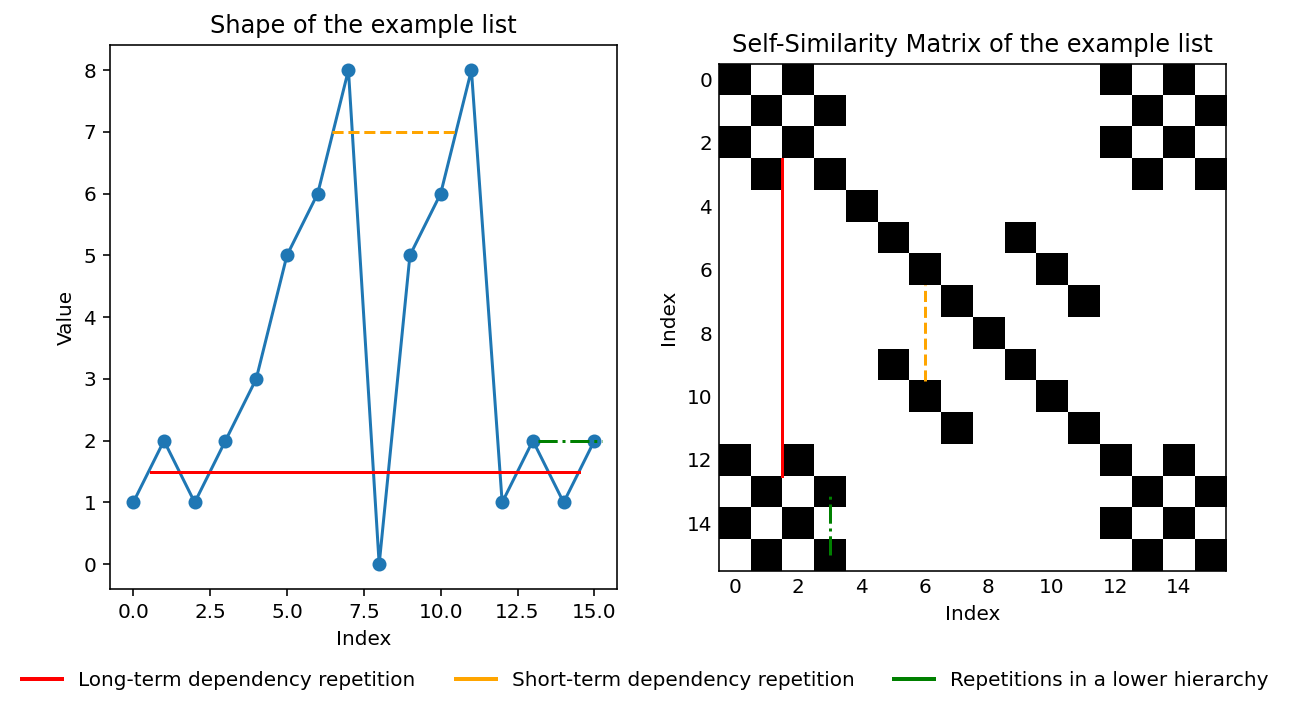

In [2]:
import numpy as np
import matplotlib.pyplot as plt

lst = [1,2,1,2,3,5,6,8,0,5,6,8,1,2,1,2]

# Create a matrix of pairwise similarities
SSM = np.zeros((len(lst), len(lst)))
for i in range(len(lst)):
    for j in range(len(lst)):
        if lst[i] == lst[j]:
            SSM[i, j] = 1

# Plot the original list and the self-similarity matrix
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(lst, marker='o')
axs[0].set_title('Shape of the example list')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Add horizontal lines with annotations
axs[0].axhline(y=1.5, xmin=1.3/len(lst), xmax=14.8/len(lst), linestyle='-', color='red')
axs[0].axhline(y=7, xmin=7/len(lst), xmax=11/len(lst), linestyle='--', color='orange')
axs[0].axhline(y=2, xmin=13.5/len(lst), xmax=15.5/len(lst), linestyle='-.', color='green')

lines = [plt.Line2D([0], [0], color='red', lw=2),
         plt.Line2D([0], [0], color='orange', lw=2),
         plt.Line2D([0], [0], color='green', lw=2)]
labels = ['Long-term dependency repetition',
          'Short-term dependency repetition',
          'Repetitions in a lower hierarchy']

axs[1].imshow(SSM, cmap='binary', interpolation='nearest')
axs[1].set_title('Self-Similarity Matrix of the example list')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Index')
axs[1].tick_params(axis='both', which='both', length=0)

# Add vertical lines with annotations
axs[1].axvline(x=1.5, ymin=3/len(lst), ymax=13/len(lst), linestyle='-', color='red')
axs[1].axvline(x=6, ymin=6/len(lst), ymax=9/len(lst), linestyle='--', color='orange')
axs[1].axvline(x=3, ymin=0.5/len(lst), ymax=2.5/len(lst), linestyle='-.', color='green')

axs[1].legend(handles=lines, labels=labels, bbox_to_anchor=(1.1, -0.25), loc=4, borderaxespad=0, ncol=3, frameon=False)
plt.savefig('how SSM works.png')
plt.show()


### 4.1 define the distance

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
data_test = pd.read_csv('./test.csv')
data_test['beat_pitch'] = data_test['beat_pitch'].apply(ast.literal_eval)

data_markov = pd.read_csv('./markov_songs_with_pitch.csv')
data_markov['beat_pitch'] = data_markov['beat_pitch'].apply(ast.literal_eval)

data_random = pd.read_csv('./random_songs.csv')
data_random['beat_pitch'] = data_random['tuple_beat_and_pitch'].apply(ast.literal_eval)

data_lstm = pd.read_csv('lstm_songs_formatted.csv')
data_lstm['beat_pitch'] = data_lstm['tuple_beat_and_pitch'].apply(ast.literal_eval)


Randomly choose one song for markov, test, and random

Define the self similarity function

In [6]:
song_0_markov = data_markov.loc[100,'beat_pitch']
song_0_test = data_test.loc[100,'beat_pitch']
song_0_random = data_random.loc[100,'beat_pitch']
song_0_lstm = data_lstm.loc[100,'beat_pitch']

In [7]:
def change_it_to_bar_vectors_12(song_0):
    """
    fill the blanks in the song
    """
    song_1 = []
    for bar in song_0:
        vec = [0] * 12
        for tup in bar:
            vec[tup[0]-1] = tup[1]%12
        song_1.append(vec)
    return song_1

In [8]:
def make_into_one_vector(song_0):
    """
    make the song into one vector
    """
    song_1 = []
    for bar in song_0:
        song_1.extend(bar)
    return song_1

In [9]:
# self similarities matrix
def self_similarity_matrix_for_beat(song_0):
    # first make it into one vector
    song_1 = make_into_one_vector(song_0)
    # calculate the self similarity matrix
    self_similarity_matrix = np.zeros((len(song_1), len(song_1)))
    for i in range(len(song_1)):
        for j in range(len(song_1)):
            similarity_score = np.dot(song_1[i], song_1[j])/(np.linalg.norm(song_1[i])*np.linalg.norm(song_1[j]))
            self_similarity_matrix[i][j] = np.exp(-1000000*(1-similarity_score))
    return self_similarity_matrix

Beat self similarity matrixes in order Markov, test and random

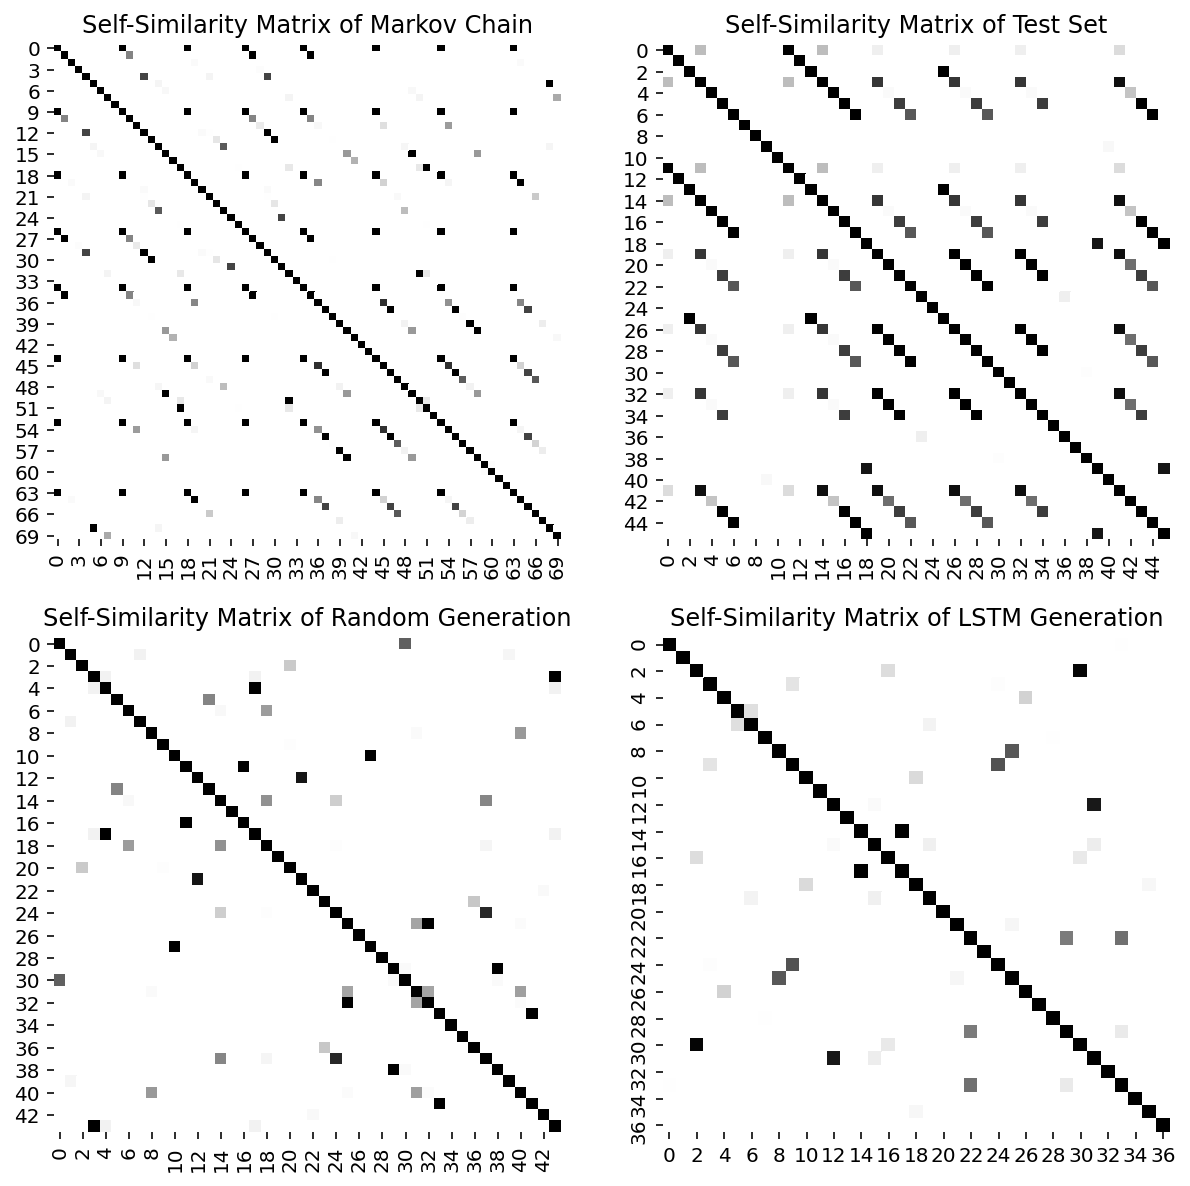

In [12]:
self_similarity_matrix_markov = self_similarity_matrix_for_beat(song_0_markov)
self_similarity_matrix_test = self_similarity_matrix_for_beat(song_0_test)
self_similarity_matrix_random = self_similarity_matrix_for_beat(song_0_random)
self_similarity_matrix_lstm = self_similarity_matrix_for_beat(song_0_lstm)

# display the subplots 2 by 2
fig, axs = plt.subplots(2, 2, figsize=(10,10))
sns.heatmap(self_similarity_matrix_markov, ax=axs[0,0], cmap='binary', cbar=False)
axs[0,0].set_title('Self-Similarity Matrix of Markov Chain')
sns.heatmap(self_similarity_matrix_test, ax=axs[0,1], cmap='binary', cbar=False)
axs[0,1].set_title('Self-Similarity Matrix of Test Set')
sns.heatmap(self_similarity_matrix_random, ax=axs[1,0], cmap='binary', cbar=False)
axs[1,0].set_title('Self-Similarity Matrix of Random Generation')
sns.heatmap(self_similarity_matrix_lstm, ax=axs[1,1], cmap='binary', cbar=False)
axs[1,1].set_title('Self-Similarity Matrix of LSTM Generation')
plt.savefig('self_similarity_matrix.png')
plt.show()


Have a comparasion between the beat-level and bar-level ssm

In [13]:
def self_similarity_matrix_for_bars(song_0):
    # first make it into one vector
    song_1 = change_it_to_bar_vectors_12(song_0)
    # calculate the self similarity matrix
    self_similarity_matrix = np.zeros((len(song_1), len(song_1)))
    for i in range(len(song_1)):
        for j in range(len(song_1)):
            self_similarity_matrix[i][j] = np.dot(song_1[i], song_1[j])/(np.linalg.norm(song_1[i])*np.linalg.norm(song_1[j]))
    return self_similarity_matrix

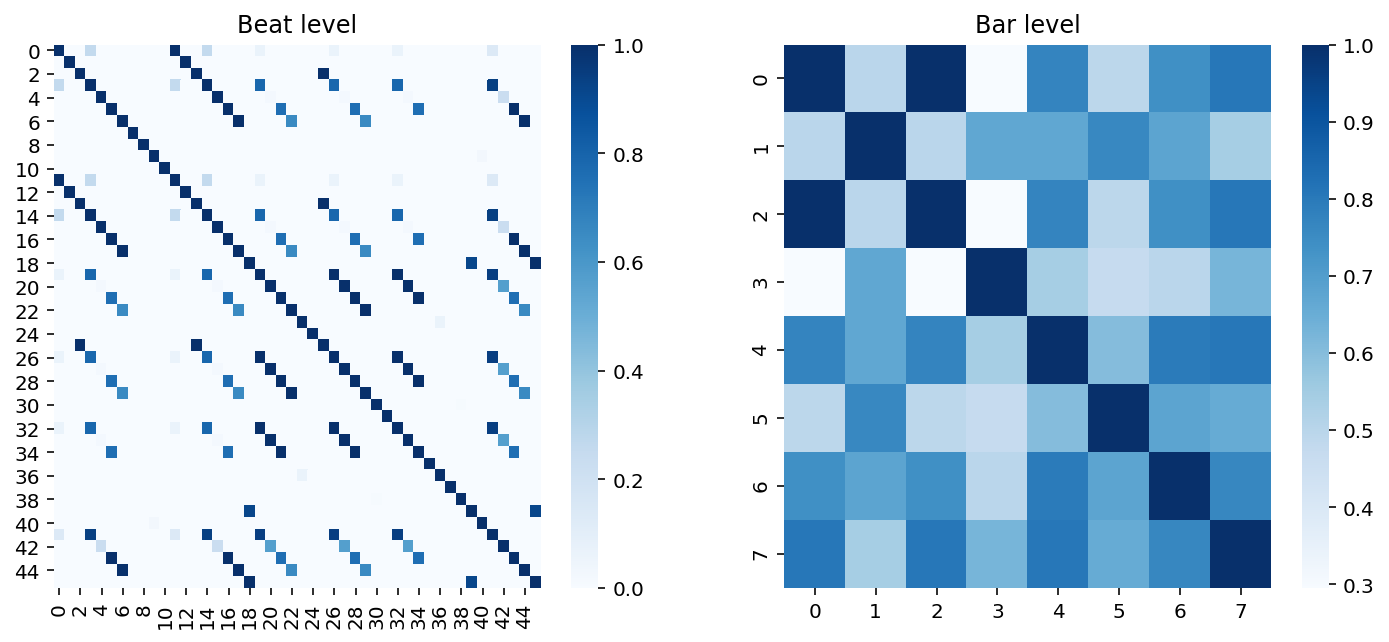

In [16]:
SSM_test_beat_level = self_similarity_matrix_for_beat(song_0_test)
SSM_test_bar_level = self_similarity_matrix_for_bars(song_0_test)

# display the subplots horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(SSM_test_beat_level, cmap='Blues', ax=ax1)
sns.heatmap(SSM_test_bar_level, cmap='Blues', ax=ax2)
ax1.set_title('Beat level')
ax2.set_title('Bar level')
plt.savefig('SSM_comparasion_between_beat_and_bar_level.png')
plt.show()

Define the score function

- Method 1: sum up the SSM
- Method 2: take the length of repetition; repetition times and repetition distance into account.

In [17]:
# simply sum up the matrix
def get_score_from_song(song):
    """
    get the score from the matrix
    """
    matrix_beat = self_similarity_matrix_for_beat(song)
    score1 = sum(sum(matrix_beat))
    norm_score1 = score1/(len(matrix_beat)**2)
    return norm_score1

In [18]:
# Load your SSM into a NumPy array
def get_score_from_ssm(ssm, threshold=0.5):
    # Define the range of diagonals to iterate over
    start_diag = -(ssm.shape[0])+1
    end_diag = ssm.shape[0]//2 - 2

    # Iterate over the diagonals of the SSM
    diags = []
    distances = []
    for i in range(start_diag, end_diag):
        diag = ssm.diagonal(i)
        sub_diags = []
        sub_diag = []
        y_index = i
        for j in range(len(diag)):
            x_index = j
            if diag[j] > threshold:
                sub_diag.append((x_index, diag[j]))
            else:
                if len(sub_diag) > 0:
                    sub_diags.append(sub_diag)
                sub_diag = []
        if len(sub_diag) > 0 and len(sub_diag) < ssm.shape[0]:
            sub_diags.append(sub_diag)
        if len(sub_diags) > 0:
            diags += sub_diags
            distances += [y_index] * len(sub_diags)

    # sort the diagonals by length
    sorted_indices = sorted(range(len(diags)), key=lambda k: len(diags[k]))
    diags = [diags[i] for i in sorted_indices]
    distances = [distances[i] for i in sorted_indices]
    
    position_list = position_list = [[pos for (pos, _) in diag] for diag in diags]

    # final statistics dict: {length: (repeated times,average_distance)}
    statistics = {}
    for i, pos_i in enumerate(position_list):
        repeated_times = 1
        average_distance = abs(distances[i])
        for j in range(i+1, len(position_list)):
            pos_j = position_list[j]
            # find if pos_i is a subset of pos_j
            if set(pos_i).issubset(set(pos_j)):
                repeated_times += 1
                average_distance += abs(distances[j])
            else:
                pass
        average_distance = average_distance / repeated_times
        statistics[len(pos_i)] = (repeated_times, average_distance)

    # get the total score by average_distance*(length^(repeated times))
    total_score = sum([value[1]*(key**value[0]) for key, value in statistics.items()]) / ssm.shape[0]
    total_score = 1 - np.exp(-total_score)
    return total_score

Evaluate the random chosen samples from markov, test, and random

In [19]:
print('Get the beat level score from summing up the ssm:')
print(f"markov: {get_score_from_song(song_0_markov):.3f}")
print(f"test:\t{get_score_from_song(song_0_test):.3f}")
print(f"random: {get_score_from_song(song_0_random):.3f}")

Get the beat level score from summing up the ssm:
markov: 0.038
test:	0.069
random: 0.037


In [20]:
# mesuring the score of meaningful repetitions
SSM_test_beat_level = self_similarity_matrix_for_beat(song_0_test)
SSM_markov_beat_level = self_similarity_matrix_for_beat(song_0_markov)
SSM_random_beat_level = self_similarity_matrix_for_beat(song_0_random)

print('Get the beat level score by taking account more factors:')
print(f"markov: {get_score_from_ssm(SSM_markov_beat_level, threshold=0.7):.3f}")
print(f"test:\t{get_score_from_ssm(SSM_test_beat_level, threshold=0.7):.3f}")
print(f"random: {get_score_from_ssm(SSM_random_beat_level, threshold=0.7):.3f}")

Get the beat level score by taking account more factors:
markov: 0.786
test:	1.000
random: 0.320


Evaluate the whole dataset

In [22]:
# Calculation of the score

# for the test data
final_test_score = []
for i in range(len(data_test)):
    song_test = data_test.loc[i,'beat_pitch']
    ssm = self_similarity_matrix_for_beat(song_test)
    score_temp = get_score_from_ssm(ssm, threshold=0.7)
    final_test_score.append(score_temp)

# for the markov data
final_markov_score = []
for i in range(len(data_markov)):
    song_markov = data_markov.loc[i,'beat_pitch']
    ssm = self_similarity_matrix_for_beat(song_markov)
    score_temp = get_score_from_ssm(ssm, threshold=0.7)
    final_markov_score.append(score_temp)

# for the random data
final_random_score = []
for i in range(len(data_random)):
    song_random = data_random.loc[i,'beat_pitch']
    ssm = self_similarity_matrix_for_beat(song_random)
    score_temp = get_score_from_ssm(ssm, threshold=0.7)
    final_random_score.append(score_temp)

# for the lstm data
final_lstm_score = []
for i in range(len(data_lstm)):
    song_lstm = data_lstm.loc[i,'beat_pitch']
    ssm = self_similarity_matrix_for_beat(song_lstm)
    score_temp = get_score_from_ssm(ssm, threshold=0.7)
    final_lstm_score.append(score_temp)

# average per dataset + max and min
print(f"dataset\taverage\tmax\tmin")
print(f"test:\t{np.mean(final_test_score):.3f}\t{np.max(final_test_score):.3f}\t{np.min(final_test_score):.3f}")
print(f"markov:\t{np.mean(final_markov_score):.3f}\t{np.max(final_markov_score):.3f}\t{np.min(final_markov_score):.3f}")
print(f"random:\t{np.mean(final_random_score):.3f}\t{np.max(final_random_score):.3f}\t{np.min(final_random_score):.3f}")
print(f"lstm:\t{np.mean(final_lstm_score):.3f}\t{np.max(final_lstm_score):.3f}\t{np.min(final_lstm_score):.3f}")

dataset	average	max	min
test:	0.978	1.000	0.303
markov:	0.848	1.000	0.465
random:	0.504	0.976	0.102
lstm:	0.298	0.898	0.000


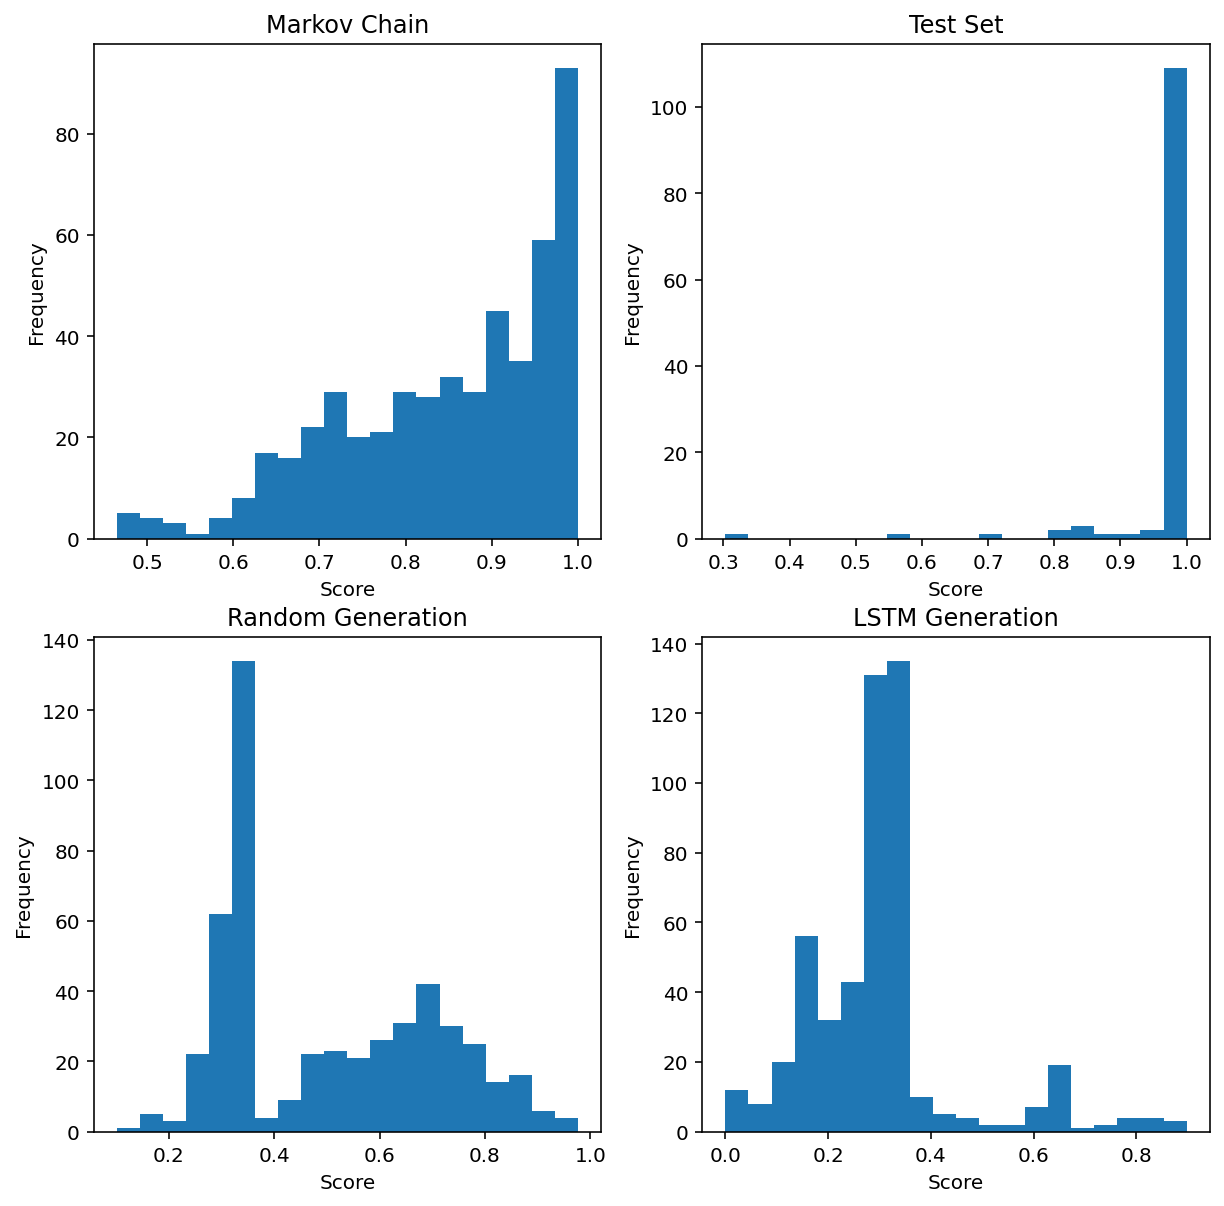

In [23]:
# plot the distribution of the scores in 4 subplots 2 by 2
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].hist(final_markov_score, bins=20)
axs[0,0].set_title('Markov Chain')
axs[0,0].set_xlabel('Score')
axs[0,0].set_ylabel('Frequency')
axs[0,1].hist(final_test_score, bins=20)
axs[0,1].set_title('Test Set')
axs[0,1].set_xlabel('Score')
axs[0,1].set_ylabel('Frequency')
axs[1,0].hist(final_random_score, bins=20)
axs[1,0].set_title('Random Generation')
axs[1,0].set_xlabel('Score')
axs[1,0].set_ylabel('Frequency')
axs[1,1].hist(final_lstm_score, bins=20)
axs[1,1].set_title('LSTM Generation')
axs[1,1].set_xlabel('Score')
axs[1,1].set_ylabel('Frequency')
plt.savefig('distribution_of_scores.png')
plt.show()

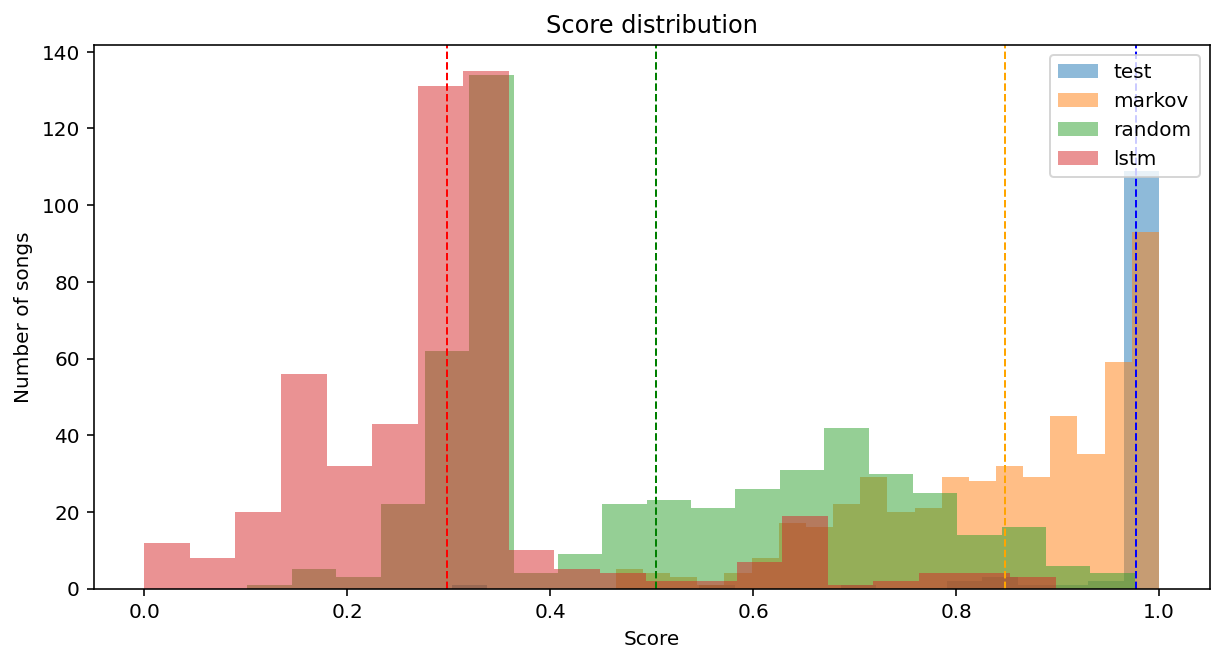

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(final_test_score, bins=20, alpha=0.5, label='test')
plt.hist(final_markov_score, bins=20, alpha=0.5, label='markov')
plt.hist(final_random_score, bins=20, alpha=0.5, label='random')
plt.hist(final_lstm_score, bins=20, alpha=0.5, label='lstm')
plt.axvline(np.mean(final_test_score), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_markov_score), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_random_score), color='green', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_lstm_score), color='red', linestyle='dashed', linewidth=1)
plt.legend(loc='upper right')
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('Number of songs')
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

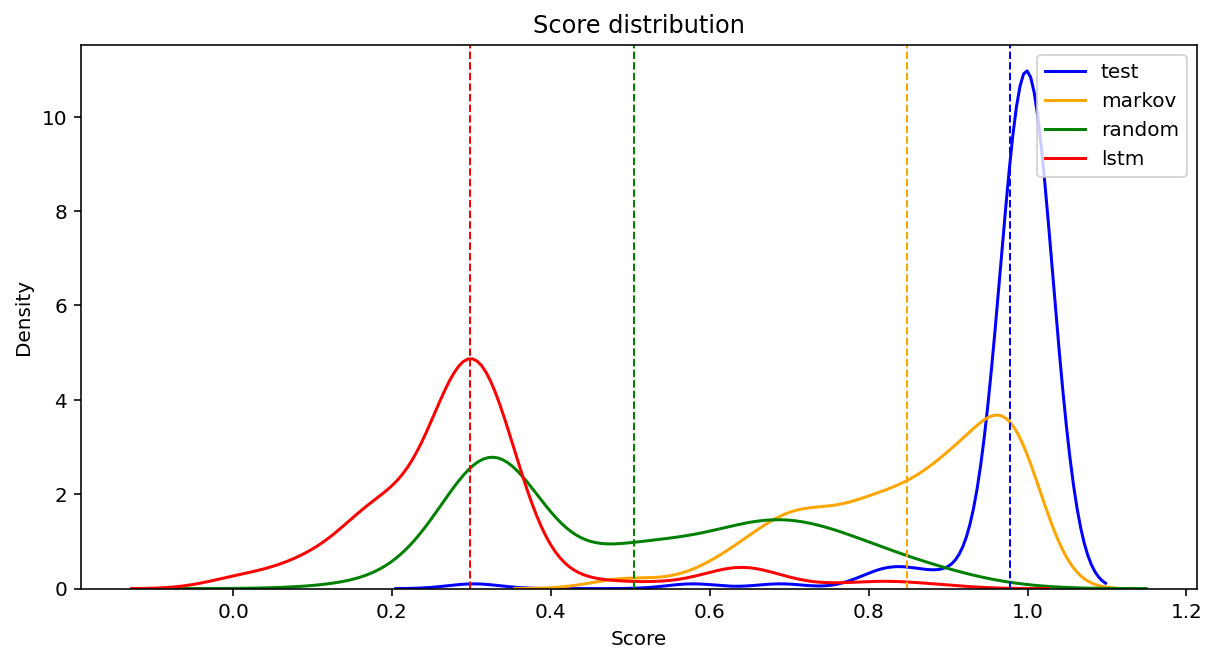

In [26]:
# make the same plot but with density
plt.figure(figsize=(10, 5))
sns.distplot(final_test_score, hist=False, kde=True, bins=20, color = 'blue', label='test')
sns.distplot(final_markov_score, hist=False, kde=True, bins=20, color = 'orange', label='markov')
sns.distplot(final_random_score, hist=False, kde=True, bins=20, color = 'green', label='random')
sns.distplot(final_lstm_score, hist=False, kde=True, bins=20, color = 'red', label='lstm')
plt.axvline(np.mean(final_test_score), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_markov_score), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_random_score), color='green', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(final_lstm_score), color='red', linestyle='dashed', linewidth=1)
plt.legend(loc='upper right')
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()